# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64", seed = 1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.63803244 -1.5
 -0.          0.          6.00063038  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
# import libraries for training

from maddpg import MADDPG_Agent
import torch
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline 

In [8]:
# train the model 

THRESHOLD_SCORE = 0.8 # if the agents achieve this average score or higher, terminate the trainiing.
SOLVED_SCORE = 0.5 # the environment is solved if the agents achieve this average score. 
DISPLAY_EVERY = 1 # display the result every DISPLAY_EVERY episodes
INITIAL_EXPLORATION = 200 # no learning for the first INITIAL_EXPLORATION episodes, and choose an action randomly  

def training(num_episodes = 3000):
    """
    This function is for traininig the model. 
   
    (input)
    - num_episodes (int): the number of episodes for training 
    (output)
    - magent: the trained multi-agent
    - score_history (list of float): list of maximum scores at all the epochs 
    - average_score_history (list of float): list of averages of maximum scores at all the epochs
    
    """
    
    magent = MADDPG_Agent(state_size, action_size, num_agents, 1) 
    score_history = [] # to store scores 
    average_score_history = [] # to store average scores
    score_part = deque(maxlen=100) # to store scores for the last 100 episodes
    is_solved = False # if the environment is solved or not
    best_average_score = 0.0 # best average score 
    best_episode_i = 0 # the episode number at which the best average score is achieved
    seed = 1 # random seed 
    np.random.seed(seed)
    
    is_learning = False # if doing the learning process or not 
    
    for episode_i in range(num_episodes): 
        
        episode_i += 1                                         # update the episode number
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        magent.reset()                                         # reset the noises
        start_time = time.time()                               # reset the start time 
        
        while True:
            
            if episode_i >= INITIAL_EXPLORATION:
                actions= magent.act_all(states)
            else: 
                actions = np.random.randn(num_agents, action_size)
                actions = np.clip(actions, -1, 1)
                
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            if episode_i == INITIAL_EXPLORATION:  
                is_learning = True
            magent.step(states, actions, rewards, next_states, dones, is_learning) # update the multi-agent    
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            
            if np.any(dones):                                  # exit loop if the episode is finished
                break
        
        elapsed_time = time.time() - start_time
        
        # store the score, compute and save the average score
        max_score = np.max(scores)
        score_history.append(max_score)
        score_part.append(max_score)
        average_score = np.mean(score_part)
        average_score_history.append(average_score)
        
        # display the current status 
        if episode_i % DISPLAY_EVERY ==0:
            print("----- episode {}, score (max among agents): {} -----".format(episode_i, max_score))
            print('average_score: {}'.format(average_score))
            print('elapsed time: {}'.format(elapsed_time))
        
        # update the best average score
        if average_score > best_average_score:
            best_average_score = average_score
            best_episode_i = episode_i 
            
            # check if the environment is solved or not
            if (best_average_score > SOLVED_SCORE) and is_solved !=True:
                print("---------- environment solved at episode {} ----------".format(episode_i))
                print('average_score: {}'.format(best_average_score)) 
                is_solved = True
                # save the weights for the trained neural networks 
                torch.save(magent.maddpg_agents[0].actor_local.state_dict(), 'check_point_agent1_actor_solved.pth')
                torch.save(magent.maddpg_agents[0].critic_local.state_dict(), 'check_point_agent1_critic_solved.pth')
                torch.save(magent.maddpg_agents[1].actor_local.state_dict(), 'check_point_agent2_actor_solved.pth')
                torch.save(magent.maddpg_agents[1].critic_local.state_dict(), 'check_point_agent2_critic_solved.pth')
 
            
        # if the average score reaches the threshold or above, then terminate the training
        if average_score > THRESHOLD_SCORE:
            elapsed_time = time.time() - start_time
            print("---------- training terminated at episode {} ----------".format(episode_i))
            print('average_score: {}'.format(average_score))
        
            break
        
    # save the weights for the trained neural networks 
    torch.save(magent.maddpg_agents[0].actor_local.state_dict(), 'check_point_agent1_actor.pth')
    torch.save(magent.maddpg_agents[0].critic_local.state_dict(), 'check_point_agent1_critic.pth')
    torch.save(magent.maddpg_agents[1].actor_local.state_dict(), 'check_point_agent2_actor.pth')
    torch.save(magent.maddpg_agents[1].critic_local.state_dict(), 'check_point_agent2_critic.pth')
        
    print("----- best score {} at epsiode {}".format(best_average_score, best_episode_i))
    
    return magent, score_history, average_score_history
    
# train the model 
magent, score_history, average_score_history = training()

----- episode 1, score (max among agents): 0.0 -----
average_score: 0.0
elapsed time: 0.0357356071472168
----- episode 2, score (max among agents): 0.0 -----
average_score: 0.0
elapsed time: 0.08849525451660156
----- episode 3, score (max among agents): 0.10000000149011612 -----
average_score: 0.033333333830038704
elapsed time: 0.055518388748168945
----- episode 4, score (max among agents): 0.0 -----
average_score: 0.02500000037252903
elapsed time: 0.023647785186767578
----- episode 5, score (max among agents): 0.0 -----
average_score: 0.020000000298023225
elapsed time: 0.02428889274597168
----- episode 6, score (max among agents): 0.0 -----
average_score: 0.016666666915019352
elapsed time: 0.025442838668823242
----- episode 7, score (max among agents): 0.0 -----
average_score: 0.014285714498588018
elapsed time: 0.023501873016357422
----- episode 8, score (max among agents): 0.0 -----
average_score: 0.012500000186264515
elapsed time: 0.0234375
----- episode 9, score (max among agents):

----- episode 71, score (max among agents): 0.0 -----
average_score: 0.014929577708244324
elapsed time: 0.023626327514648438
----- episode 72, score (max among agents): 0.0 -----
average_score: 0.014722222462296486
elapsed time: 0.02404952049255371
----- episode 73, score (max among agents): 0.0 -----
average_score: 0.014520548181991055
elapsed time: 0.027547836303710938
----- episode 74, score (max among agents): 0.0 -----
average_score: 0.014324324557910094
elapsed time: 0.024201393127441406
----- episode 75, score (max among agents): 0.0 -----
average_score: 0.014133333563804626
elapsed time: 0.024440288543701172
----- episode 76, score (max among agents): 0.0 -----
average_score: 0.013947368648491408
elapsed time: 0.0249326229095459
----- episode 77, score (max among agents): 0.0 -----
average_score: 0.013766233990718793
elapsed time: 0.02463388442993164
----- episode 78, score (max among agents): 0.0 -----
average_score: 0.013589743811350603
elapsed time: 0.024417877197265625
----

----- episode 137, score (max among agents): 0.0 -----
average_score: 0.01750000027939677
elapsed time: 0.02592635154724121
----- episode 138, score (max among agents): 0.0 -----
average_score: 0.01750000027939677
elapsed time: 0.027344942092895508
----- episode 139, score (max among agents): 0.0 -----
average_score: 0.01750000027939677
elapsed time: 0.02544546127319336
----- episode 140, score (max among agents): 0.0 -----
average_score: 0.01750000027939677
elapsed time: 0.02417445182800293
----- episode 141, score (max among agents): 0.0 -----
average_score: 0.01750000027939677
elapsed time: 0.024028778076171875
----- episode 142, score (max among agents): 0.09000000171363354 -----
average_score: 0.018400000296533107
elapsed time: 0.053316593170166016
----- episode 143, score (max among agents): 0.0 -----
average_score: 0.018400000296533107
elapsed time: 0.02599620819091797
----- episode 144, score (max among agents): 0.0 -----
average_score: 0.018400000296533107
elapsed time: 0.0276

----- episode 201, score (max among agents): 0.0 -----
average_score: 0.020200000330805778
elapsed time: 0.37742114067077637
----- episode 202, score (max among agents): 0.0 -----
average_score: 0.019300000313669442
elapsed time: 0.43038320541381836
----- episode 203, score (max among agents): 0.0 -----
average_score: 0.019300000313669442
elapsed time: 0.38372802734375
----- episode 204, score (max among agents): 0.0 -----
average_score: 0.019300000313669442
elapsed time: 0.37712860107421875
----- episode 205, score (max among agents): 0.0 -----
average_score: 0.019300000313669442
elapsed time: 0.3778877258300781
----- episode 206, score (max among agents): 0.0 -----
average_score: 0.019300000313669442
elapsed time: 0.3848731517791748
----- episode 207, score (max among agents): 0.0 -----
average_score: 0.019300000313669442
elapsed time: 0.41705751419067383
----- episode 208, score (max among agents): 0.10000000149011612 -----
average_score: 0.020300000328570603
elapsed time: 0.7745728

----- episode 267, score (max among agents): 0.0 -----
average_score: 0.007800000123679638
elapsed time: 0.3854072093963623
----- episode 268, score (max among agents): 0.0 -----
average_score: 0.007800000123679638
elapsed time: 0.4216024875640869
----- episode 269, score (max among agents): 0.10000000149011612 -----
average_score: 0.008800000138580798
elapsed time: 0.8443572521209717
----- episode 270, score (max among agents): 0.0 -----
average_score: 0.008800000138580798
elapsed time: 0.37662744522094727
----- episode 271, score (max among agents): 0.0 -----
average_score: 0.008800000138580798
elapsed time: 0.37607884407043457
----- episode 272, score (max among agents): 0.0 -----
average_score: 0.008800000138580798
elapsed time: 0.41745448112487793
----- episode 273, score (max among agents): 0.10000000149011612 -----
average_score: 0.00980000015348196
elapsed time: 0.7915370464324951
----- episode 274, score (max among agents): 0.0 -----
average_score: 0.00980000015348196
elapsed 

----- episode 329, score (max among agents): 0.10000000149011612 -----
average_score: 0.03710000058636069
elapsed time: 0.8288965225219727
----- episode 330, score (max among agents): 0.10000000149011612 -----
average_score: 0.038100000601261855
elapsed time: 0.8757624626159668
----- episode 331, score (max among agents): 0.10000000149011612 -----
average_score: 0.03910000061616301
elapsed time: 0.8413374423980713
----- episode 332, score (max among agents): 0.10000000149011612 -----
average_score: 0.04010000063106418
elapsed time: 0.840937614440918
----- episode 333, score (max among agents): 0.0 -----
average_score: 0.04010000063106418
elapsed time: 0.39099574089050293
----- episode 334, score (max among agents): 0.0 -----
average_score: 0.04010000063106418
elapsed time: 0.4179348945617676
----- episode 335, score (max among agents): 0.0 -----
average_score: 0.04010000063106418
elapsed time: 0.386763334274292
----- episode 336, score (max among agents): 0.10000000149011612 -----
aver

----- episode 390, score (max among agents): 0.30000000447034836 -----
average_score: 0.0815000013075769
elapsed time: 3.071645736694336
----- episode 391, score (max among agents): 0.10000000149011612 -----
average_score: 0.08250000132247806
elapsed time: 1.4393572807312012
----- episode 392, score (max among agents): 0.5000000074505806 -----
average_score: 0.08660000137984752
elapsed time: 5.205622673034668
----- episode 393, score (max among agents): 0.30000000447034836 -----
average_score: 0.089600001424551
elapsed time: 3.5560357570648193
----- episode 394, score (max among agents): 0.09000000171363354 -----
average_score: 0.08950000142678619
elapsed time: 0.8871393203735352
----- episode 395, score (max among agents): 0.09000000171363354 -----
average_score: 0.08940000142902135
elapsed time: 0.8586242198944092
----- episode 396, score (max among agents): 0.4000000059604645 -----
average_score: 0.09240000147372485
elapsed time: 4.609863519668579
----- episode 397, score (max among

----- episode 450, score (max among agents): 0.09000000171363354 -----
average_score: 0.14990000240504742
elapsed time: 0.8689405918121338
----- episode 451, score (max among agents): 0.30000000447034836 -----
average_score: 0.15190000243484975
elapsed time: 3.632438898086548
----- episode 452, score (max among agents): 0.09000000171363354 -----
average_score: 0.15190000243484975
elapsed time: 0.8699347972869873
----- episode 453, score (max among agents): 0.10000000149011612 -----
average_score: 0.15190000243484975
elapsed time: 0.8321084976196289
----- episode 454, score (max among agents): 0.10000000149011612 -----
average_score: 0.15200000243261458
elapsed time: 0.878129243850708
----- episode 455, score (max among agents): 0.09000000171363354 -----
average_score: 0.15190000243484975
elapsed time: 0.8659460544586182
----- episode 456, score (max among agents): 0.4000000059604645 -----
average_score: 0.15500000247731804
elapsed time: 5.046159267425537
----- episode 457, score (max a

----- episode 510, score (max among agents): 0.10000000149011612 -----
average_score: 0.2602000040002167
elapsed time: 1.5509750843048096
----- episode 511, score (max among agents): 0.09000000171363354 -----
average_score: 0.2602000040002167
elapsed time: 0.8312606811523438
----- episode 512, score (max among agents): 1.4000000208616257 -----
average_score: 0.27330000419169664
elapsed time: 14.969466924667358
----- episode 513, score (max among agents): 0.09000000171363354 -----
average_score: 0.2732000041939318
elapsed time: 0.8458867073059082
----- episode 514, score (max among agents): 0.0 -----
average_score: 0.2723000041767955
elapsed time: 0.5435459613800049
----- episode 515, score (max among agents): 0.10000000149011612 -----
average_score: 0.2724000041745603
elapsed time: 0.879357099533081
----- episode 516, score (max among agents): 0.10000000149011612 -----
average_score: 0.2724000041745603
elapsed time: 1.4394474029541016
----- episode 517, score (max among agents): 2.6000

----- episode 570, score (max among agents): 0.09000000171363354 -----
average_score: 0.6263000093586742
elapsed time: 0.9942798614501953
----- episode 571, score (max among agents): 0.800000011920929 -----
average_score: 0.6283000093884766
elapsed time: 8.613346815109253
----- episode 572, score (max among agents): 0.20000000298023224 -----
average_score: 0.6283000093884766
elapsed time: 1.4088244438171387
----- episode 573, score (max among agents): 1.9000000283122063 -----
average_score: 0.6453000096417963
elapsed time: 20.530370235443115
----- episode 574, score (max among agents): 0.10000000149011612 -----
average_score: 0.6463000096566975
elapsed time: 0.9040751457214355
----- episode 575, score (max among agents): 0.09000000171363354 -----
average_score: 0.6462000096589327
elapsed time: 0.8565967082977295
----- episode 576, score (max among agents): 1.600000023841858 -----
average_score: 0.6612000098824501
elapsed time: 17.909170627593994
----- episode 577, score (max among agen

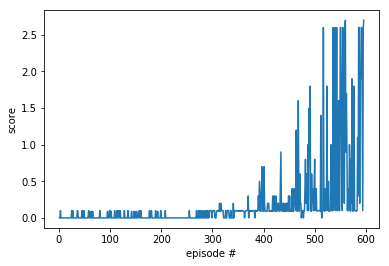

In [11]:
# display the history of the scores 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(score_history)+1), score_history)
plt.ylabel("score")
plt.xlabel("episode #")
plt.savefig("score.eps")
plt.show()

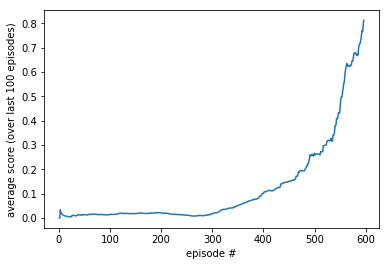

In [12]:
# display the history of the average score (over the last 100 episodes)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_score_history)+1), average_score_history)
plt.ylabel("average score (over last 100 episodes)")
plt.xlabel("episode #")
plt.savefig("average_score.eps")
plt.show()